# HW3 - Stock Movement Prediction

作業檔案：
- hw3.ipynb

資料：
https://www.sharecast.com/index/SP_500/prices/download

- train.csv: S&P 500 訓練資料(2009-2017)
- test.csv: S&P 500 測試資料(2018)


## 環境

請填寫當前執行使用的環境。

|環境|名稱|版本|
|-|-|-|
|作業系統|Ubuntu|18.04 LTS|
|程式執行環境|jupyter notebook|1.0.0|
|python 版本|python3|3.6.9|
|安裝環境|pip|20.1|

## 安裝

請填寫安裝套件需要的指令

```sh
pip install -r requirements.txt
```

## 計算資源

請填寫執行程式所需要的計算資源，請確保所有資源限制在單一個人桌上型電腦且能夠以總市價低於 5 萬的手段取得。

|計算資源|答案|
|-|-|
|使用 CPU 核心數|6|
|記憶體需求|$\leq 4$GB|
|有無使用 GPU|無|
|GPU 版本|無|
|GPU 記憶體需求|$\leq 1$GB|

## 資料前處理

### 觀察資料型態與分佈

首先快速檢視資料的特徵，共有6個欄位：

- Date
- Open Price
- Close Price
- High Price
- Low Price
- Volume

除了Date外，所有欄位都是數值欄位。

In [1]:
# Read data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_data_path = './train.csv'
test_data_path = './test.csv'

train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

print(train_df.info())
print()
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         2264 non-null   object 
 1   Open Price   2264 non-null   float64
 2   Close Price  2264 non-null   float64
 3   High Price   2264 non-null   float64
 4   Low Price    2264 non-null   float64
 5   Volume       2264 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 106.2+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         252 non-null    object 
 1   Open Price   252 non-null    float64
 2   Close Price  252 non-null    float64
 3   High Price   252 non-null    float64
 4   Low Price    252 non-null    float64
 5   Volume       252 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory u

捨去Date欄位，這意味著將每一筆資料的間隔視為等距1日，雖然股票遇到假日會休市，但為了方便後續處理，這裡就直接當成等間距採樣的資料。
接著把各欄位的分佈視覺化，發現前4個欄位的分佈有雙峰，Volume欄位為單峰，雖然不是最適當的作法，但這裡仍用常態分佈來做標準化。

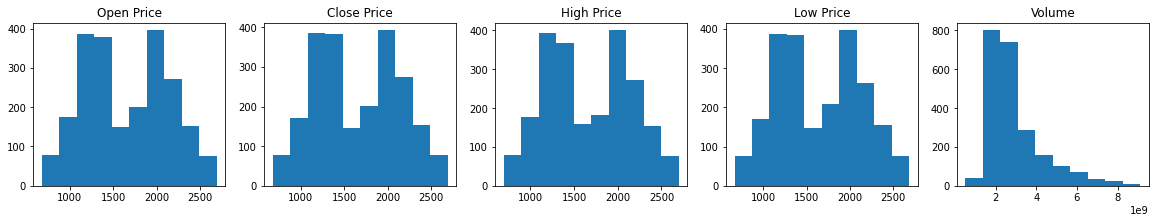

In [2]:
# Drop unnecessary columns

drop_col_names = ['Date'] # !--- or you can modify it to drop the columns you don't want ---!

train_df.drop(columns=drop_col_names, inplace=True)
test_df.drop(columns=drop_col_names, inplace=True)

i = 1
fig = plt.figure(figsize=(20,3))
for key in train_df.keys():
    ax = fig.add_subplot(1,5,i)
    ax.hist(train_df[key])
    ax.set_title(key)
    i = i + 1

### 製作目標資料（標籤）

這裡的目標資料為「隔天的股票漲跌」，因此只會有漲、跌兩種類別，以收盤價為基準來衡量當天的漲跌，將此種資訊新增至`Tomorrow Movement`欄位，以0代表跌、1代表漲。

In [3]:
# Add the column `Tomorrow Movement` by comparing the `Close Price` with the previous days as the training target

train_df['Tomorrow Movement'] = np.where(train_df['Close Price'].diff() >= 0, 1, 0)
test_df['Tomorrow Movement'] = np.where(test_df['Close Price'].diff() >= 0, 1, 0)

train_df['Tomorrow Movement'] = train_df['Tomorrow Movement'].shift(-1)
test_df['Tomorrow Movement'] = test_df['Tomorrow Movement'].shift(-1)

train_df.drop(train_df.tail(1).index,inplace=True)
test_df.drop(test_df.tail(1).index,inplace=True)

print(train_df.head())
print(train_df.tail())

   Open Price  Close Price  High Price  Low Price      Volume  \
0      902.99       931.80      934.73     899.35  4048270080   
1      929.17       927.45      936.63     919.53  5413910016   
2      931.17       934.70      943.85     927.28  5392620032   
3      927.45       906.65      927.45     902.37  4704940032   
4      905.73       909.73      910.00     896.81  4991549952   

   Tomorrow Movement  
0                0.0  
1                1.0  
2                0.0  
3                1.0  
4                0.0  
      Open Price  Close Price  High Price  Low Price      Volume  \
2258     2683.02      2684.57     2692.64    2682.40  1933795072   
2259     2684.22      2683.34     2685.35    2678.13  1383888512   
2260     2679.09      2680.50     2682.74    2677.96  1103808384   
2261     2682.10      2682.62     2685.64    2678.91  1149108352   
2262     2686.10      2687.54     2687.66    2682.69  1126089856   

      Tomorrow Movement  
2258                0.0  
2259      

將標籤與特徵資料分離。

In [4]:
# Divide x and y data

train_x_df = train_df.drop(columns=['Tomorrow Movement'])
train_y_df = train_df['Tomorrow Movement']

test_x_df = test_df.drop(columns=['Tomorrow Movement'])
test_y_df = test_df['Tomorrow Movement']

print(train_x_df.shape)
print(train_x_df.head())
print(train_y_df.shape)
print(train_y_df.head())
print('-----')
print(test_x_df.shape)
print(test_x_df.head())
print(test_y_df.shape)
print(test_y_df.head())

(2263, 5)
   Open Price  Close Price  High Price  Low Price      Volume
0      902.99       931.80      934.73     899.35  4048270080
1      929.17       927.45      936.63     919.53  5413910016
2      931.17       934.70      943.85     927.28  5392620032
3      927.45       906.65      927.45     902.37  4704940032
4      905.73       909.73      910.00     896.81  4991549952
(2263,)
0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
Name: Tomorrow Movement, dtype: float64
-----
(251, 5)
   Open Price  Close Price  High Price  Low Price      Volume
0     2683.73      2695.81     2695.89    2682.36  1846463232
1     2697.85      2713.06     2714.37    2697.77  2090595328
2     2719.31      2723.99     2729.29    2719.07  2100767744
3     2731.33      2743.15     2743.45    2727.92  1918869120
4     2742.67      2747.71     2748.51    2737.60  1894823936
(251,)
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Tomorrow Movement, dtype: float64


捨棄有NaN的欄位。

In [5]:
# Drop rows with NaN values

train_df = train_df.dropna()
test_df = test_df.dropna()

print(train_df.shape)

(2263, 6)


### 時間序列的處理

股票為時間序列資料，可以分解成幾種元素：
- T(t)： Trend component，代表整題資料的走勢
- S(t)： Seasonal component，代表資料在固定時間週期內的循環訊號，通常以日、週、月、季
- C(t)： Cyclic component，代表長時間的循環訊號，但無固定週期或者週期很長，這裡會把此元素併入S(t)
- I(t)： Irregular component，無法以上面的元素表示的訊號，即雜訊

整體資料y(t)可以用上述元素的兩種形式來組成
1. 加法形式 $ y(t) = T(t) + S(t) + I(t) $
1. 乘法形式 $ y(t) = T(t) * S(t) * I(t) $

經實驗後發現，這裡要處理的資料用乘法形式來表現成果較佳，所有欄位的時間序列分解如下面所示。可以發現訓練資料的trend元素是往上走的，且數值範圍與其他元素相差過大，經實驗發現如果不把此因素去除，機器學習時受trend影響過大，會直接把預測結果猜為全部上漲（即預測結果全為1），因此這裡依照乘法形式把trend元素從資料中移除，資料剩下$ y(t) = S(t) * I(t) $，只由Seasonal與Irregular來主宰。

另外在實驗時發現，季節性元素的週期不宜設定過大，這裡將`period`設為3，表示某天的資料僅會受過去3天的資料影響，換句話說，上星期、上個月、甚至去年的資料跟當天的資料幾乎沒有關聯。

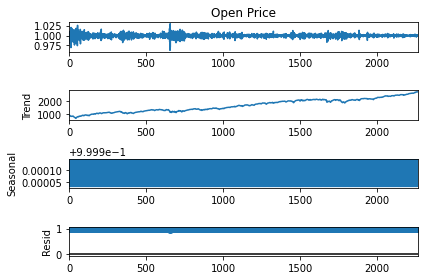

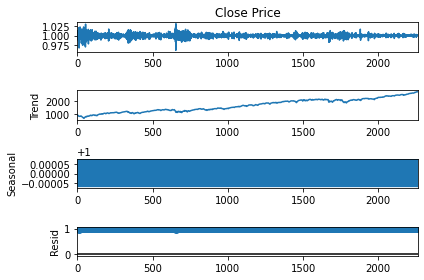

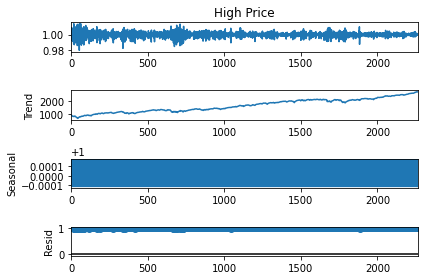

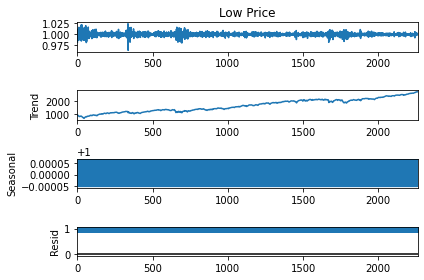

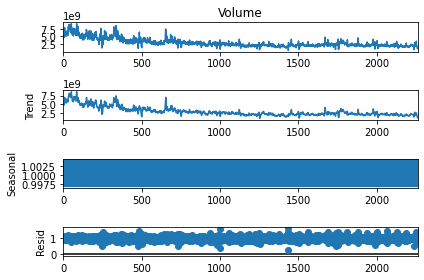

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
for key in train_x_df.keys():
    timeseries = seasonal_decompose(train_x_df[key], model='multiplicative', period=3)
    timeseries.trend.fillna(method='bfill', inplace=True)
    timeseries.trend.fillna(method='ffill', inplace=True)
    train_x_df[key] = train_x_df[key] / timeseries.trend
    timeseries.plot()
    plt.show()
    

測試資料也同訓練資料做一樣的處理，處理完後的資料概覽如下。

In [7]:
for key in test_x_df.keys():
    timeseries = seasonal_decompose(test_x_df[key], model='multiplicative', period=3)
    timeseries.trend.fillna(method='bfill', inplace=True)
    timeseries.trend.fillna(method='ffill', inplace=True)
    test_x_df[key] = test_x_df[key] / timeseries.trend
    #timeseries.plot()
    #plt.show()
    

In [8]:
print('-------- Training Data --------')
print(train_x_df.describe())
print('\n-------- Testing Data --------')
print(test_x_df.describe())

-------- Training Data --------
        Open Price  Close Price   High Price    Low Price       Volume
count  2263.000000  2263.000000  2263.000000  2263.000000  2263.000000
mean      0.999985     0.999989     0.999990     0.999983     0.998746
std       0.004675     0.005089     0.003409     0.004114     0.100752
min       0.962816     0.961909     0.979801     0.963618     0.282725
25%       0.997862     0.997624     0.998406     0.997829     0.944671
50%       1.000115     1.000158     1.000183     1.000097     0.995761
75%       1.002153     1.002396     1.001765     1.002069     1.051002
max       1.029886     1.030720     1.014032     1.024289     1.650989

-------- Testing Data --------
       Open Price  Close Price  High Price   Low Price      Volume
count  251.000000   251.000000  251.000000  251.000000  251.000000
mean     1.000045     0.999983    1.000004    1.000037    0.998744
std      0.005194     0.005073    0.003947    0.005177    0.096158
min      0.974841     0.97482

### 資料正規化

將資料約範圍轉換到[0,1]，並且平均值為0。

In [9]:
# Normalize data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_x_df)

normalized_train_x_df = scaler.transform(train_x_df)
normalized_train_x_df = np.transpose(normalized_train_x_df)

normalized_train_x_df = pd.DataFrame({
    'Open Price': normalized_train_x_df[0],
    'Close Price': normalized_train_x_df[1],
    'High Price': normalized_train_x_df[2],
    'Low Price': normalized_train_x_df[3],
    'Volume': normalized_train_x_df[4],
})

normalized_test_x_df = scaler.transform(test_x_df)
normalized_test_x_df = np.transpose(normalized_test_x_df)
normalized_test_x_df = pd.DataFrame({
    'Open Price': normalized_test_x_df[0],
    'Close Price': normalized_test_x_df[1],
    'High Price': normalized_test_x_df[2],
    'Low Price': normalized_test_x_df[3],
    'Volume': normalized_test_x_df[4],
})

print('-------- Training Data Quick View --------')
print(normalized_train_x_df.head())
print('\n-------- Training Labels --------')
print(train_y_df.head())

-------- Training Data Quick View --------
   Open Price  Close Price  High Price  Low Price    Volume
0   -4.205563     0.104075   -1.145631  -4.255655 -1.798656
1    1.875199    -0.813930   -0.551522   1.104684  0.939344
2    0.442094     2.507816    2.471269   2.892715  0.438949
3    1.396214    -2.221897    0.113756  -1.721563 -0.628564
4   -2.016915     1.632939   -2.065357   0.270103  0.399317

-------- Training Labels --------
0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
Name: Tomorrow Movement, dtype: float64


## Logistic Regression

利用Logistic Regression來做二元分類器，訓練與測試結果精度達0.79左右，算是不錯。

In [10]:
# Train & Predict using Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_model =  LogisticRegression(random_state=0, solver='liblinear')
lr_model.fit(normalized_train_x_df, train_y_df)

lr_training_acc = lr_model.score(normalized_train_x_df, train_y_df)
print('training accuracy: {}'.format(lr_training_acc))

lr_predict_test_result = lr_model.predict(normalized_test_x_df)
lr_testing_acc = lr_model.score(normalized_test_x_df, test_y_df)
print('testing accuracy: {}'.format(lr_testing_acc))

print('\npredicted testing labels:')
print(lr_predict_test_result)

training accuracy: 0.794078656650464
testing accuracy: 0.7928286852589641

predicted testing labels:
[1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]


### 分類結果評估

In [11]:
# Print precision, recall, fbeta-score and confusion matrix

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

print('precision, recall, fbeta-score:')
print(precision_recall_fscore_support(test_y_df, lr_predict_test_result, average='weighted'))
print('\nconfusion matrix(tn, fp, fn, tp):')
tn, fp, fn, tp = confusion_matrix(test_y_df, lr_predict_test_result).ravel()
print((tn, fp, fn, tp))

precision, recall, fbeta-score:
(0.792783851805056, 0.7928286852589641, 0.7926040448487973, None)

confusion matrix(tn, fp, fn, tp):
(91, 28, 24, 108)


## SVM

利用SVM來做二元分類器，訓練與測試結果精度達0.79左右，算是不錯。

In [12]:
# Train & Predict with SVC

from sklearn.svm import SVC

svc_model = SVC(C=1, kernel='linear', probability=True)
svc_model.fit(normalized_train_x_df, train_y_df)

svc_training_acc = svc_model.score(normalized_train_x_df, train_y_df)
print('training accuracy: {}'.format(svc_training_acc))

svc_predict_test_result = svc_model.predict(normalized_test_x_df)
svc_testing_acc = svc_model.score(normalized_test_x_df, test_y_df)
print('testing accuracy: {}'.format(svc_testing_acc))

print('\npredicted testing labels:')
print(svc_predict_test_result)

training accuracy: 0.7927529827662395
testing accuracy: 0.7928286852589641

predicted testing labels:
[1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]


### 分類結果評估

In [13]:
# Print precision, recall, fbeta-score and confusion matrix

print('precision, recall, fbeta-score:')
print(precision_recall_fscore_support(test_y_df, svc_predict_test_result, average='weighted'))
print('\nconfusion matrix(tn, fp, fn, tp):')
tn, fp, fn, tp = confusion_matrix(test_y_df, svc_predict_test_result).ravel()
print((tn, fp, fn, tp))

precision, recall, fbeta-score:
(0.7929865762038418, 0.7928286852589641, 0.792451649341332, None)

confusion matrix(tn, fp, fn, tp):
(90, 29, 23, 109)


## Neural Network

製作類神經網路模型前，需要先將Label轉換為One-hot encoding的形式。

In [14]:
# Define NN output groundtruth

falling_prob = pd.DataFrame(data=np.where(train_y_df == 0, 1, 0)[:])
train_y_df = pd.DataFrame(data=np.where(train_y_df == 0, 0, 1)[:])
train_y_df = pd.concat( [ falling_prob, train_y_df ], axis=1, ignore_index=True )

falling_prob = pd.DataFrame(data=np.where(test_y_df == 0, 1, 0)[:])
test_y_df = pd.DataFrame(data=np.where(test_y_df == 0, 0, 1)[:])
test_y_df = pd.concat( [ falling_prob, test_y_df ], axis=1, ignore_index=True )

print('-------- Training Labels --------')
print(train_y_df.shape)
print(train_y_df.head())

-------- Training Labels --------
(2263, 2)
   0  1
0  1  0
1  0  1
2  1  0
3  0  1
4  1  0


NN結構如下：

類型|大小|激發函數
---|---|---
Linear|(5, 100)|ReLU
Linear|(100, 2)|Softmax

超參數資訊如下：
- Batch size： 100
- Optimizer： AdaGrad
- Loss function： BCEWithLogitsLoss (Cross Entropy的變形)

經實驗，batch size若太大精度會不高，太小則會拉長訓練時間但精度不會提升太多；Optimizer選用AdaGrad則是藉可變動的learning rate來提升初期訓練速度，但在後期又可以收斂；Loss function因為是二元分類問題，因此選用固定班底的Cross Entropy。

In [15]:
# Define NN structure

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

class M_NN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(M_NN, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
        self.softmax = torch.nn.Softmax(1)

    def forward(self, x):
        h = self.linear1(x)
        acti_out = F.relu(h)
        acti_out = self.linear2(h)
        y_pred = self.softmax(acti_out)
        return y_pred


# N = batch size, D_in = input size, H = hidden size, D_out = output size
N, D_in, H, D_out = 100, 5, 100, 2  # !--- You can modify here ---!

# create tensor
train = torch.tensor(normalized_train_x_df.values.astype(np.float32))
train_target = torch.tensor(train_y_df.values.astype(np.float32)) 
train_tensor = TensorDataset(train, train_target) 
train_loader = DataLoader(train_tensor, batch_size = N, shuffle = True)

model = M_NN(D_in, H, D_out)
criterion = torch.nn.BCEWithLogitsLoss() # !--- You can modify here ---!
optimizer = torch.optim.Adagrad(model.parameters(), initial_accumulator_value=0.1)
 # !--- You can modify here ---!


# Train NN
# !--- You can modify here ---!

for t in range(1001):
    for batch_x, batch_y in train_loader: 
        y_pred = model(batch_x)
        loss = criterion(y_pred, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (t%100 == 0):
        print('epoch: %d - loss: %.10f' % (t, loss.item()))

epoch: 0 - loss: 0.6523808837
epoch: 100 - loss: 0.6351314783
epoch: 200 - loss: 0.5944130421
epoch: 300 - loss: 0.6171208024
epoch: 400 - loss: 0.5964610577
epoch: 500 - loss: 0.6548215151
epoch: 600 - loss: 0.5771522522
epoch: 700 - loss: 0.6443138719
epoch: 800 - loss: 0.5642848015
epoch: 900 - loss: 0.5821752548
epoch: 1000 - loss: 0.6036472917


訓練與測試結果精度達0.79左右，算是不錯。

In [16]:
# Predict

nn_predict_train_y = model(train)
result_train = np.where(nn_predict_train_y[:, 0] > nn_predict_train_y[:, 1], 1, 0) # !-- You can modify here --!
print('training accuracy:')
print(accuracy_score(train_y_df[0], result_train))

nn_predict_test_y = model(torch.tensor(normalized_test_x_df.values.astype(np.float32)))
result_test = np.where(nn_predict_test_y[:, 0] > nn_predict_test_y[:, 1], 1, 0) # !-- You can modify here --!
print('\ntesting accuracy:')
print(accuracy_score(test_y_df[0], result_test))

print('\npredicted testing prob:')
print(nn_predict_test_y[:5,:])
print('\npredicted testing labels:')
print(result_test)

training accuracy:
0.7984975695978789

testing accuracy:
0.7888446215139442

predicted testing prob:
tensor([[1.5123e-11, 1.0000e+00],
        [3.3924e-01, 6.6076e-01],
        [8.8459e-03, 9.9115e-01],
        [9.8179e-01, 1.8207e-02],
        [2.2387e-01, 7.7613e-01]], grad_fn=<SliceBackward>)

predicted testing labels:
[0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1
 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0
 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 0
 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1
 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0
 1 1 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1]


### 分類結果評估

In [17]:
# Print precision, recall, fbeta-score and confusion matrix

print('\nprecision, recall, fbeta-score:')
print(precision_recall_fscore_support(test_y_df[0], result_test, average='weighted'))
print('\nconfusion matrix(tn, fp, fn, tp):')
tn, fp, fn, tp = confusion_matrix(test_y_df[0], result_test).ravel()
print((tn, fp, fn, tp))


precision, recall, fbeta-score:
(0.7895566669492244, 0.7888446215139442, 0.788175863177168, None)

confusion matrix(tn, fp, fn, tp):
(110, 22, 31, 88)


# Discussion

總結上述3種分類方法評估結果如下：

|分類方法|Precision|Recall|F-beta Score|
|:---:|---:|---:|---:|
|Logistic|0.7928|0.7928|0.7926|
|SVM|0.7930|0.7928|0.7925|
|NN|0.7896|0.7888|0.7882|

可以看出Logistic與SVM的表現幾乎相同，NN稍微差一點點，推測可能是層數太少，若再加深或許能增加精度。

#### 此次模型是否適用於其他資料集

由於這次訓練資料的trend元素走勢是持續上升，若是遇到有升有降的trend時不確定能不能用同樣方法處理，另外時間序列在此是選擇乘法形式，若是遇到加法形式的資料時便需要重新處理，模型本身方面，若是時間序列問題解決，Logistic與SVM理應可以通用，NN則容易因訓練資料不足而無法適用於其他資料。

#### 如何改善分類模型

Logistic沒有更動太多參數便達到此精度；SVM經實驗後發現不同的kernal function對結果沒有影響太大，因此回歸最簡單的linear；NN對結果影響最大的部份在於loss function，分類問題若使用MSE作為loss function會不容易收斂（loss 容易卡在0.6 ~ 0.7），使用Cross entropy才是較恰當的。